<a href="https://colab.research.google.com/github/Kevin2558/Data_Science_Borrador/blob/main/07_Deep_Learning/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Grad-CAM**

Técnica de visualización que permite entender que partes de una imagen influyeron más en la toma de decisiones de una red neuronal convolucional.

Grad-CAM genera un mapa de calor superpuesto a la imagen original, que muestra las regiones más importantes que contribuyeron a la predicción del modelo. Este mapa está basado en los gradientes que fluyen hacia las últimas capas convolucionales.

In [1]:
!pip -q install torch torchvision grad-cam pillow requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.8 MB/s e

In [2]:
!pip install -q --upgrade grad-cam

In [3]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt, torch, requests, io
from torchvision import transforms, utils, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.auto import tqdm

In [4]:
# Dataset

tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_ds = datasets.CIFAR10('data', train=True, download=True, transform=tfms)
test_ds = datasets.CIFAR10('data', train=False, transform=tfms)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0)

100%|██████████| 170M/170M [00:19<00:00, 8.88MB/s]


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,1,1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,1,1),nn.BatchNorm2d(128),nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 10)
        )
    def forward(self,x): return self.classifier(self.features(x))

model = SimpleCNN().to(device)
print(f'Parámetros: {sum(p.numel() for p in model.parameters())}')

Parámetros: 620810


In [6]:
criterion = nn.CrossEntropyLoss() # Para clasificación multiple (incluye softmax)
# Optimizador Adam
optimizer = torch.optim.Adam(model.parameters(), # Parámetros a optimizar
                             lr=1e-3, # Tasa de aprendizaje
                             weight_decay=1e-4 # Regularización L2
                             )

In [8]:
# Precisión
def accuracy(net, loader):
  net.eval(); correct = total = 0
  with torch.no_grad():
    for xb, yb in loader:
      pred = net(xb.to(device)).argmax(1).cpu()
      correct += (pred==yb).sum().item()
      total += yb.size(0)
  return correct/total

# Entrenamiento
epochs = 5
for ep in range(1,epochs+1):
  model.train()
  for xb, yb in tqdm(train_dl, desc=f'Epoch {ep}/{epochs}', leave=False):
    xb, yb = xb.to(device), yb.to(device)
    pred = model(xb)
    loss = criterion(pred, yb)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  val_acc = accuracy(model, test_dl)
  print(f'Época {ep:02d} | val acc: {val_acc*100:.2f}%')

# Guardar el modelo
torch.save(model, 'cnn_cifar10.pt')
print('Modelo guardado como cnn_cifar10.pt en el directorio de Colab')

Epoch 1/5:   0%|          | 0/1563 [00:00<?, ?it/s]

Época 01 | val acc: 68.56%


Epoch 2/5:   0%|          | 0/1563 [00:00<?, ?it/s]

Época 02 | val acc: 73.22%


Epoch 3/5:   0%|          | 0/1563 [00:00<?, ?it/s]

Época 03 | val acc: 72.98%


Epoch 4/5:   0%|          | 0/1563 [00:00<?, ?it/s]

Época 04 | val acc: 75.78%


Epoch 5/5:   0%|          | 0/1563 [00:00<?, ?it/s]

Época 05 | val acc: 77.79%
Modelo guardado como cnn_cifar10.pt en el directorio de Colab


In [9]:
torch.save(model.state_dict(), 'cnn_cifar10_sd.pt')

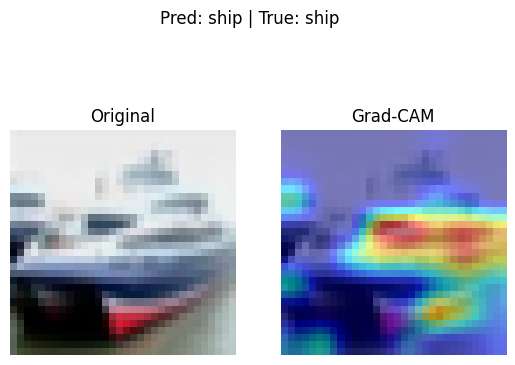

In [11]:
# Cargamos la CNN casera entrenada anteriormente
model = torch.load('cnn_cifar10.pt', map_location='cpu', weights_only=False).eval()

# Tomar un lote de prueba (del DataLoader que ya tenemos)
imgs, labels = next(iter(test_dl))
img, label = imgs[1:2], labels[1]

# Preparar Grad-CAM sobre la última conv de nuestra red
target_layer = model.features[-3]
img = img.to(device)

with GradCAM(model=model, target_layers=[target_layer]) as cam:
    grayscale_cam = cam(input_tensor=img)[0]

# Des-normalizar para visualizar
def denorm(t):
  mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
  std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1)
  return torch.clamp(t*std+mean, 0, 1)

rgb = denorm(img.cpu()[0]).permute(1,2,0).numpy()
cam_img = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)

classes = test_ds.classes
model.to(device).eval()
pred_idx = model(img.to(device)).argmax(1).item()
true_idk = label.item()
pred = model(img).argmax(1).item()

true = label.item()
title = f'Pred: {classes[pred]} | True: {classes[true]}'
plt.subplot(1,2,1); plt.imshow(rgb); plt.axis('off') ;plt.title('Original')
plt.subplot(1,2,2); plt.imshow(cam_img); plt.axis('off') ;plt.title('Grad-CAM')
plt.suptitle(title, fontsize=12)
plt.show()


Interpretación rápida:
* Las zonas rojas indican contribución postivca alta a la clase predicha
* Si la red acertó y el rojo cubre el objeto, aprendió el patrón correcto
* Si se enfoca en el fondo, indica posible sesgo, este sería un buen punto de partida para el transfer learning

# **Transfer Learning**

Técnica de ML, especialmente útil en redes neuronales profundas, que consiste en aprovechar el conocimiento aprendido por un modelo entrenado previamente en una tarea para aplicarlo a una nueva tarea relacionada, usando sus capas básicas y luego entrenando para capas más complejas.

En lugar de entrenar un modelo de cero, lo que suele requerir muchos datos y tiempo de cómputa, se siguen los siguientes pasos:

1. Se toma un modelo preentrenado (en este coso ResNet-18)
2. Se reutilizan sus capas iniciales (ya entrenadas para detectar patrones generales como bordes, texturas, formas)
3. Se adapta el modelo:
  * Congelando las primeras capas (no se actualizan durante el nuevo entrenamiento)
  * Reemplazando y entrenando las últimas capas para la nueva tarea

Las ventajas que representa son requerir menos datos etiquetados, ahorrar tiempo de entrenamiento y suele mejorar el rendimiento en tareas específicas.

Este método suele evitar el overfitting de una CNN entrenada de cero con pocos datos.

Entre sus usos comúnes se encuentran:

* Visión por computadora (imagen médica, astronomía, seguridad)
* Preprocesamiento de lenguaje natural (clasificación de texto, traducción)
* Audio (reconocimiento de voz)

## **ResNet-18**

Arquitectura de red neuronal convolucional profunda introducida por Microsoft Research.

Antes de ResNet, redes muy profundas (con muchas capas) sufrían de un problema llamado *dregradación:* al aumentar la profundidad, la precisión comenzaba a empeorar (no por overfitting, sino por dificultades al entrenar).

ResNet soluciona esto introduciendo bloques residuales, que permiten que la red "salte" capas cuando sea necesario. Esto hace que:

* Sea más fácil entrenar redes muy profundas
* Se mantenga el flujo del gradiente durante el backpropagation (mejorando la estabilidad del entrenamiento)

Estrategia 1: Feature Extractor

Entrenar 2 - 3 épocas suele mejorar el 80% de accuracy en CIFAR-10

In [12]:
from torchvision import models

In [13]:
model = models.resnet18(weights='IMAGENET1K_V1')

for p in model.parameters():
  p.requires_grad = False

model.fc = nn.Linear(512, 10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
model = model.to(device)
model.fc.to(device)

Linear(in_features=512, out_features=10, bias=True)

In [17]:
val_dl = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2)

In [20]:
tf_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

tf_val = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.226))
])

train_ds = datasets.CIFAR10('data', train=True, download=True, transform=tf_train)
val_ds = datasets.CIFAR10('data', train=False, download=True, transform=tf_val)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=2)

In [16]:
def accuracy(net, loader):
  net.eval(); correct = total = 0
  with torch.no_grad():
    for xb, yb in loader:
      pred = net(xb.to(device)).argmax(1).cpu()
      correct += (pred==yb).sum().item()
      total += yb.size(0)
  return correct/total

In [21]:
# Entrenamiento
epochs = 3
for ep in range(1,epochs+1):
  model.train()
  pbar = tqdm(train_dl, desc=f'Epoch {ep}/{epochs}')
  for xb, yb in pbar:
    xb, yb = xb.to(device), yb.to(device)
    loss = criterion(model(xb), yb)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_postfix(loss=f'{loss.item():.3f}')
  val_acc = accuracy(model, val_dl)
  print(f'Época {ep:02d} | val acc: {val_acc*100:.2f}%')

# Guardar el modelo
torch.save(model.state_dict(), 'resnet18_feature_extractor_cifar10.pt')
print('Modelo guardado en Colab')

Epoch 1/3:   0%|          | 0/1563 [00:00<?, ?it/s]

Época 01 | val acc: 79.00%


Epoch 2/3:   0%|          | 0/1563 [00:00<?, ?it/s]

Época 02 | val acc: 79.56%


Epoch 3/3:   0%|          | 0/1563 [00:00<?, ?it/s]

Época 03 | val acc: 79.73%
Modelo guardado en Colab


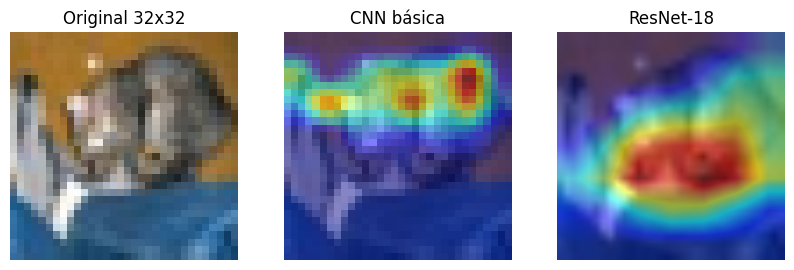

In [24]:
def denorm(t):
  mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1).to(t.device)
  std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1).to(t.device)
  return torch.clamp(t*std+mean, 0, 1)

img, label = val_ds[0]
img = img.unsqueeze(0).to(device)

# CNN Básica

cnn = SimpleCNN().to(device)
cnn.load_state_dict(torch.load('cnn_cifar10_sd.pt', map_location=device))
cnn.eval()
layer_cnn = cnn.features[-3]

tf_cnn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

img32, label = test_ds[0]
img32 = img32.unsqueeze(0).to(device)

with GradCAM(model=cnn, target_layers=[layer_cnn]) as cam:
    cam_cnn = cam(input_tensor=img32)[0]

to224 = transforms.Resize(224)

img224 = to224(img32.squeeze(0).cpu())
img224 = img224.unsqueeze(0).to(device)

resnet = models.resnet18(weights='IMAGENET1K_V1')
resnet.fc = nn.Linear(512, 10)
resnet.load_state_dict(torch.load('resnet18_feature_extractor_cifar10.pt', map_location=device))

resnet = resnet.to(device).eval()
layer_resnet = resnet.layer4[-1]

with GradCAM(model=resnet, target_layers=[layer_resnet]) as cam:
    cam_res = cam(input_tensor=img224)[0]

rgb32 = denorm(img32[0]).permute(1,2,0).cpu().numpy()
overlay_cnn = show_cam_on_image(rgb32, cam_cnn, use_rgb=True)

rgb224 = denorm(img224.cpu()[0]).permute(1,2,0).numpy()
overlay_res = show_cam_on_image(rgb224, cam_res, use_rgb=True)

fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].imshow(rgb32)
ax[0].set_title('Original 32x32')
ax[0].axis('off')
ax[1].imshow(overlay_cnn)
ax[1].set_title('CNN básica')
ax[1].axis('off')
ax[2].imshow(overlay_res)
ax[2].set_title('ResNet-18')
ax[2].axis('off')
plt.show()


Estrategia 2: Fine-Tuning Parcial

3 épocas extractor + 3 épocas fine-tune parcial suele rozar 90% en CIFAR-10.

In [ ]:
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(512, 10)

for name, p in model.named_parameters():
  if name.startswith('layer4') or name.startswith('fc'):
    p.requires_grad = True
  else:
    p.requires_grad = False

optimizer = torch.optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
], weight_decay=1e-4)

Ahora vendria el entrenamiento igual al anterior.

Estrategia 3:

Requiere 8-10 épocas y buen data-augmentation (RandAugm, CutMix) para no sobre-ajustar.

In [25]:
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(512, 10)

for p in model.parameters():
  p.requires_grad = True

optimizer = torch.optim.Adam([
    {'params': model.fc.parameters(), 'lr': 1e-3},
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.layer3.parameters(), 'lr': 1e-3},
    {'params': list(model.layer1.parameters())+
               list(model.layer2.parameters()), 'lr': 5e-5}
], weight_decay=1e-4)

Ahora vendria el entrenamiento igual al anterior.

# **Data-Augmentation**

Técnica utilizada en ML, especialmente en visión por computador, para aumentar artificialmente el tamaño y la diversidad de un conjunto de atos aplicando transformaciones a las muestras originales.

Esto nos ayuda en lo siguiente:
* Evita el overfitting, al hacer que el modelo vea versiones variadas de los datos
* Mejora la generalización, haciendo qu el modelo sea más robusto a variaciones comunes en el mundo real
* Permite entrenar con pocos datos, al generar más ejemplos sin necesidad de recolectar nuevas muestras

In [26]:
from torchvision import transforms, models
from torchvision.transforms import v2

RandAugment se ejecuta antes de pasar a tensor.

Mixup / CutMix operan sobre tensores y devuelven etiquetas soft-labels (distribuciones).

La función de pérdida debe aceptar soft labels: usa criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [ ]:
tf_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandAugment(num_ops=2, magnitude=9),
    v2.MixUp(alpha=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

tf_val = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.226))
])

train_ds = datasets.CIFAR10('data', train=True, download=True, transform=tf_train)
val_ds = datasets.CIFAR10('data', train=False, download=True, transform=tf_val)

Proceso completo: Qué hace RandAugment se aplica en la pipeline de transforms.

Mix / CutMix se aplican aleatoriamente (70% de los mini-batches) con alpha = 1.0.

Se usa la estrategia fine-tuning parcial (layer4 + fc) con lr diferenciados.

Después de aprox 8 épocas deberías ver una val-accuracy = 92% (+- 1%) en GPU T4.

Ajusta epochs, alpha, o la probabilidad prob si quieres experimentar.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import random

# Mixup y CutMix

def _rand_bbox(W, H, lam):
  cut_rat = (1. -lam)**0.5
  cut_w = int(W*cut_rat)
  cut_h = int(H*cut_rat)
  cx = random.randint(W)
  cy = random.randint(H)
  bbx1 = max(0, cx-cut_w//2)
  bby1 = max(0, cy-cut_h//2)
  bbx2 = min(W, cx+cut_w//2)
  bby2 = min(H, cy+cut_h//2)
  return bbx1, bby1, bbx2, bby2

def mixup_cutmix(batch, alpha=1.0, prob=0.5):
  imgs, labels = batch
  if random.random() > prob:
    return imgs.to(device), labels.to(device)
  lam = torch.distributions.Beta(alpha, alpha).sample().item()
  idx = torch.randperm(imgs.size(0))
  imgs2, labels2 = imgs[idx], labels[idx]
  if random.random() < 0.5:
    mixed = lam * imgs + (1-lam)*imgs2
  else:
    bbx1, bby1, bbx2, bby2 = _rand_bbox(imgs.size(3), imgs.size(2), lam)
    mixed = imgs.clone()
    mixed[:, :, bby1:bby2, bbx1:bbx2] = imgs2[:, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2-bbx1)*(bby2-bby1))/(imgs.size(-1)*imgs.size(-2))
    targets = (labels, labels2, lam)
  return mixed.to(device), targets

def mixup_loss(criterion, pred, targets):
  y1, y2, lam = targets
  return lam*criterion(pred, y1) + (1-lam)*criterion(pred, y2)

# Modelo
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(512, 10)

for name, p in model.named_parameters():
  if name.startswith('layer4') or name.startswith('fc'):
    p.requires_grad = True
  else:
    p.requires_grad = False

model = model.to(device)

opt = torch.optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
], weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

def evaluate(net, loader):
  net.eval(); correct=0; total=0
  with torch.no_grad():
    for xb, yb in loader:
      xb, yb = xb.to(device), yb.to(device)
      pred = net(xb).argmax(1)
      correct += (pred==yb).sum().item()
      total += yb.size(0)
  return correct/total

epochs = 8
for ep in range(1,epochs+1):
  model.train()
  pbar = tqdm(train_dl, desc=f'Epoch {ep}/{epochs}', leave=False)
  for imgs, labs in pbar:
    imgs, targets = mixup_cutmix((imgs, labs), alpha=1.0, prob=0.7)
    preds = model(imgs)
    loss = mixup_loss(criterion, preds, targets) if isinstance(targets, tuple) else criterion(preds, targets)
    loss.backward()
    opt.step()
    opt.zero_grad()
    pbar.set_postfix(loss=f'{loss.item():.3f}')
  val_acc = evaluate(model, val_dl)
  print(f'Época {ep:02d} | val acc: {val_acc*100:.2f}%')

torch.save(model.state_dict(), 'resnet18_cifar10_finetuned.pt')
print('Modelo fine-tuneado guardado en Colab')